/tmp/ipython-input-1-2151122755.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock_data = yf.download(stock_symbol, start="2013-01-01", end="2023-01-01", progress=False)['Close']
/tmp/ipython-input-1-2151122755.py:16: FutureWarning: YF.download() has changed argument auto_adjust default to True
  nifty_data = yf.download(nifty_symbol, start="2013-01-01", end="2023-01-01", progress=False)['Close']
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
1971/1971 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 0.0145
Epoch 2/50
1971/1971 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 6.0632e-04
Epoch 3/50
1971/1971 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 4.2582e-04
Epoch 4/50
1971/1971 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - loss: 3.9509e-04
Epoch 5/50
1971/1971 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 3.8561e-04
Epoch 6/50
1971/1971 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 4.0645e-04
Epoch 7/50
1971/1971 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 3.2712e-04
Epoch 8/50
1971/1971 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 2.6353e-04
Epoch 9/50
1971/1971 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 3.1834e-04
Epoch 10/50
1971/1971 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 2.7168e-04
Epoch 11/50
1971/1971 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 2.6491e-04
Epoch 12/50
1971/1971 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - loss: 2.2649e-04
Epoch 13/50
1971/1971 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - loss: 2.2037e-04
Epoch 14/50
1971/1971 ━━━━━━━━━━━━━━━━━━━━

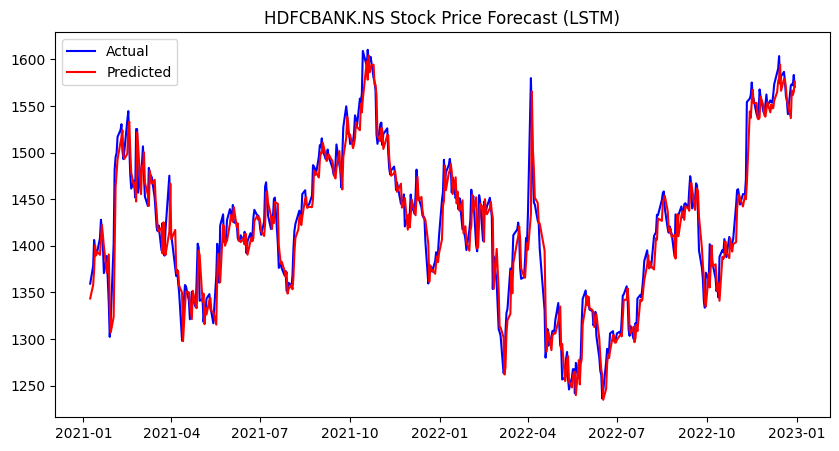

MSE: 494.9879
RMSE: 22.2483
MAPE: 1.14%


In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

# Download stock and NIFTY data
stock_symbol = 'HDFCBANK.NS'
nifty_symbol = '^NSEI'
stock_data = yf.download(stock_symbol, start="2013-01-01", end="2023-01-01", progress=False)['Close']
nifty_data = yf.download(nifty_symbol, start="2013-01-01", end="2023-01-01", progress=False)['Close']

# Train-Test Split
train_size = int(len(stock_data) * 0.8)
train_stock = stock_data[:train_size]
test_stock = stock_data[train_size:]
train_nifty = nifty_data[:train_size]
test_nifty = nifty_data[train_size:]

# Normalize Data
scaler = MinMaxScaler(feature_range=(0, 1))
train_stock_scaled = scaler.fit_transform(train_stock.values.reshape(-1, 1))
test_stock_scaled = scaler.transform(test_stock.values.reshape(-1, 1))

# Function to create sequences for LSTM
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

# Parameters
seq_length = 3

# Create sequences
X_train, y_train = create_sequences(train_stock_scaled, seq_length)
X_test, y_test = create_sequences(test_stock_scaled, seq_length)

# Reshape for LSTM
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Build LSTM Model
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(seq_length, 1)),
    LSTM(50),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')

# Train Model
model.fit(X_train, y_train, epochs=50, batch_size=1, verbose=1)

# Predict
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)

# Plot Results
plt.figure(figsize=(10,5))
plt.plot(test_stock.index[-len(y_test):], scaler.inverse_transform(y_test.reshape(-1, 1)), label="Actual", color="blue")
plt.plot(test_stock.index[-len(predictions):], predictions, label="Predicted", color="red")
plt.legend()
plt.title(f"{stock_symbol} Stock Price Forecast (LSTM)")
plt.show()

# Evaluation Metrics
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

mse = mean_squared_error(y_test_actual, predictions)
rmse = np.sqrt(mse)
mape = mean_absolute_percentage_error(y_test_actual, predictions) * 100

# Print Results
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAPE: {mape:.2f}%")
